# Forward Kinematics (2D)

In [1]:
#%matplotlib notebook
from matplotlib import pylab as plt
#import numpy as np
import autograd.numpy as np
from numpy import sin, cos, pi, matrix, random, identity
from __future__ import division
from math import atan2
from IPython import display
from ipywidgets import interact, fixed
import autograd

## Coordinate Transformation

In [2]:
def trans(x, y, a):
    '''create a 2D transformation'''
    s = sin(a)
    c = cos(a)
    return matrix([[c, -s, x],
                   [s,  c, y],
                   [0,  0, 1]])

def from_trans(m):
    '''get x, y, theta from transform matrix'''
    return [m[0, -1], m[1, -1], atan2(m[1, 0], m[0, 0])]

In [3]:
trans(0, 0, 0)

matrix([[ 1., -0.,  0.],
        [ 0.,  1.,  0.],
        [ 0.,  0.,  1.]])

## Parameters of robot arm

In [4]:

l = [0, 3, 2, 1] * 5
N = len(l) - 1  # number of links
max_len = sum(l)
a = random.random_sample(N)  # angles of joints
T0 = trans(0, 0, 0)  # base

## Forward Kinematics

In [5]:
def forward_kinematics(T0, l, a):
    T = [T0]
    for i in range(len(a)):
        Ti = T[-1] * trans(l[i], 0, a[i])
        T.append(Ti)
    Te = T[-1] * trans(l[-1], 0, 0)  # end effector
    T.append(Te)
    return T

In [6]:
chains = {
    'Head' : ['HeadYaw', 'HeadPitch'],
    'LArm' : ['LShoulderPitch', 'LShoulderRoll', 'LElbowYaw', 'LElbowRoll', 'LWristYaw'],#, 'LHand'],
    'LLeg' : ['LHipYawPitch', 'LHipRoll', 'LHipPitch', 'LKneePitch', 'LAnklePitch', 'LAnkleRoll'],
    'RLeg' : ['RHipYawPitch', 'RHipRoll', 'RHipPitch', 'RKneePitch', 'RAnklePitch', 'RAnkleRoll'],
    'RArm' : ['RShoulderPitch', 'RShoulderRoll', 'RElbowYaw', 'RElbowRoll', 'RWristYaw'],#, 'RHand']
}

alpha, a, d, theta = 0, 0, 0, 0 # For readability
transform_elements = { # All coordinates in the previous joint's coordinate system
    'HeadYaw'           : (alpha, a, d, theta),
    'HeadPitch'         : (alpha -pi/2, a, d, theta -pi/2),
    
    'LShoulderPitch'    : (alpha -pi/2, a, d, theta),
    'LShoulderRoll'     : (alpha +pi/2, a, d, theta),
    'LElbowYaw'         : (alpha +pi/2, a, d +0.105, theta), #TODO: Add elbow offset
    'LElbowRoll'        : (alpha -pi/2, a, d, theta),
    'LWristYaw'         : (alpha +pi/2, a, d +0.055_95, theta),

    'RShoulderPitch'    : (alpha -pi/2, a, d, theta),
    'RShoulderRoll'     : (alpha +pi/2, a, d, theta),
    'RElbowYaw'         : (alpha +pi/2, a, d +0.105, theta),
    'RElbowRoll'        : (alpha -pi/2, a, d, theta),
    'RWristYaw'         : (alpha +pi/2, a, d +0.055_95, theta),

    'LHipYawPitch'      : (alpha -3/4*pi, a, d, theta -pi/2),
    'LHipRoll'          : (alpha -pi/2, a, d, theta +pi/4),
    'LHipPitch'         : (alpha +pi/2, a, d, theta),
    'LKneePitch'        : (alpha, a -0.100, d, theta),
    'LAnklePitch'       : (alpha, a -0.102_9, d, theta),
    'LAnkleRoll'        : (alpha -pi/2, a, d, theta),
    
    'RHipYawPitch'      : (alpha -pi/4, a, d, theta -pi/2),
    'RHipRoll'          : (alpha -pi/2, a, d, theta -pi/4),
    'RHipPitch'         : (alpha +pi/2, a, d, theta),
    'RKneePitch'        : (alpha, a -0.100, d, theta),
    'RAnklePitch'       : (alpha, a -0.102_9, d, theta),
    'RAnkleRoll'        : (alpha -pi/2, a, d, theta),
}
transforms = dict(transform_elements)

In [7]:
def local_trans(joint_name, joint_angle):
        '''calculate local transformation of one joint

        :param str joint_name: the name of joint
        :param float joint_angle: the angle of joint in radians
        :return: transformation
        :rtype: 4x4 matrix
        '''
        alpha, a, d, theta = transform_elements[joint_name]
        
        theta += joint_angle

        sa, ca = np.sin(alpha), np.cos(alpha)
        st, ct = np.sin(theta), np.cos(theta)

        return matrix([
            [   ct,     st,    0,      a],
            [st*ca,  ct*ca,  -sa,  -sa*d],
            [st*sa,  ct*sa,   ca,   ca*d],
            [    0,      0,    0,      1],
        ])

def forward_kinematics(joints):
    '''forward kinematics

    :param joints: {joint_name: joint_angle}
    '''
    for chain_joints in chains.values():
        T = identity(4)
        for joint in chain_joints:
            angle = joints[joint]
            Tl = local_trans(joint, angle)
            # YOUR CODE HERE
            T = T @ Tl

            transforms[joint] = T

np.set_printoptions(precision=6, suppress=True)

In [8]:
trans = local_trans('HeadYaw', pi/2)
print(trans, "\n")
vector = np.array([2, 3, 4, 1])
print(vector)
vector = trans @ vector.T
vector /= vector[0, -1]
vector

[[ 0.  1.  0.  0.]
 [ 1.  0. -0. -0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]] 

[2 3 4 1]


matrix([[3., 2., 4., 1.]])

In [9]:
def trans_3d(x, y, z, roll, pitch, yaw):
        '''calculate local transformation of one joint

        :param str joint_name: the name of joint
        :param float joint_angle: the angle of joint in radians
        :return: transformation
        :rtype: 4x4 matrix
        '''
        translation = matrix([
            [1,  0,  0,  x],
            [0,  1,  0,  y],
            [0,  0,  1,  z],
            [0,  0,  0,  1],
        ])
        
        sr, sp, sy, = sin(roll), sin(pitch), sin(yaw)
        cr, cp, cy, = cos(roll), cos(pitch), cos(yaw)

        rot_roll = matrix([
            [1,  0,    0,  0],
            [0,  cr, -sr,  0],
            [0,  sr,  cr,  0],
            [0,   0,   0,  1],
        ])

        rot_pich = matrix([
            [cp,  0,  sp,  0],
            [0,   1,   0,  0],
            [-sp, 0,  cp,  0],
            [  0, 0,   0,  1],
        ])

        rot_yaw = matrix([
            [cy, -sy,  0,  0],
            [sy,  cy,  0,  0],
            [ 0,   0,  1,  0],
            [ 0,   0,  0,  1],
        ])

        # YOUR CODE HERE
        #print(joint_angle)
        return translation @ rot_yaw @ rot_pich @ rot_roll

In [10]:
def draw_robot(target_point=None):
    X = []
    Y = []
    Z = []
    
    # for transform in transforms.values():
    #     point = np.array([0, 0, 0, 1])
    #     point = transform @ point
    #     #print(point)
    #     X.append(point[0, 0])
    #     Y.append(point[0, 1])
    #     Z.append(point[0, 2])
    #     assert point[0, 3] == 1
    
    AXIS_1 = Y
    AXIS_2 = Z
    
    #rot = local_trans("TestYaw", -pi/10) @ local_trans("TestPitch", pi/30)
    #rot = local_trans("TestYaw", 0) @ local_trans("TestPitch", 0)
    rot = matrix([
        [ 0.946,  0.309,  0.099,  0.   ],
        [-0.307,  0.951, -0.032,  0.   ],
        [-0.105,  0.   ,  0.995,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  1.   ]
    ])
    # rot = matrix([
    #     [1., 0., 0., 0.],
    #     [0., 1., 0., 0.],
    #     [0., 0., 1., 0.],
    #     [0., 0., 0., 1.]
    # ])
    
    reference_floor = [
        np.array([-0.5, -0.5, 0, 0.5]),
        np.array([-0.5, 0.5, 0, 0.5]),
        np.array([0.5, 0.5, 0, 0.5]),
        np.array([0.5, -0.5, 0, 0.5]),
        np.array([-0.5, -0.5, 0, 0.5]),
    ]
    reference_ceiling = [
        np.array([-0.5, -0.5, 0.5, 0.5]),
        np.array([-0.5, 0.5, 0.5, 0.5]),
        np.array([0.5, 0.5, 0.5, 0.5]),
        np.array([0.5, -0.5, 0.5, 0.5]),
        np.array([-0.5, -0.5, 0.5, 0.5]),
    ]
    
    for point in reference_floor:
        point = rot @ point
        X.append(point[0, 0])
        Y.append(point[0, 1])
        Z.append(point[0, 2])
    
    plt.plot(AXIS_1, AXIS_2)
    X.clear()
    Y.clear()
    Z.clear()
    
    for point in reference_ceiling:
        point = rot @ point
        X.append(point[0, 0])
        Y.append(point[0, 1])
        Z.append(point[0, 2])
    
    plt.plot(AXIS_1, AXIS_2)
    X.clear()
    Y.clear()
    Z.clear()
    
    transforms["Torso"] = matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, +0.333_09],
        [0, 0, 0, 1],
    ])

    arm_rot = matrix([
        [ 0., -1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.],
    ])

    # arm_rot = matrix([
    #     [ 1.,  0.,  0.,  0.],
    #     [ 0.,  1.,  0.,  0.],
    #     [ 0.,  0.,  1.,  0.],
    #     [ 0.,  0.,  0.,  1.],
    # ])
    
    translations = {
        'Head' : np.array([0,      0, 0.333_09 + 0.126_5, 0.0], dtype=np.float64),
        'LArm' : np.array([0,  0.098, 0.333_09 + 0.100,   0.0], dtype=np.float64),
        'RArm' : np.array([0, -0.098, 0.333_09 + 0.100,   0.0], dtype=np.float64),
        'LLeg' : np.array([0,  0.050, 0.333_09 - 0.085,   0.0], dtype=np.float64),
        'RLeg' : np.array([0, -0.050, 0.333_09 - 0.085,   0.0], dtype=np.float64),
    }
    for chain_name, joint_list in chains.items():
        mod = translations[chain_name]

        for joint_name in joint_list:
            transform = transforms[joint_name]
            point = np.array([0, 0, 0, 1], dtype=np.float64)
            if chain_name.endswith("Arm"):
                point = rot @ arm_rot @ transform @ point
            else: 
                point = rot @ transform @ point
            point += mod
            #print(joint_name, point)
            X.append(point[0, 0])
            Y.append(point[0, 1])
            Z.append(point[0, 2])
            assert point[0, 3] == 1
            
        plt.plot(AXIS_1, AXIS_2)
        plt.scatter(AXIS_1, AXIS_2)
        X.clear()
        Y.clear()
        Z.clear()
    
    #print(Y, Z)
    #plt.scatter(AXIS_1, AXIS_2)
    if target_point is not None:
        target_point = rot @ target_point
        plt.scatter(target_point[0, 1], target_point[0, 2])
    plt.show()

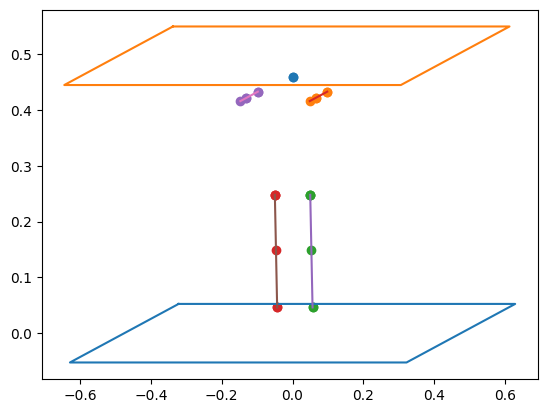

In [11]:
joints = dict(transforms)
for joint_name in joints.keys():
    joints[joint_name] = 0

#print(joints['LShoulderPitch'])
#joints['LShoulderPitch'] = pi/2
#joints['LShoulderRoll'] = pi/4
# joints['RHipPitch'] = -3*pi/4
# joints['RKneePitch'] = +1*pi/4
# joints['RKneeRoll'] = pi/2

# joints['RHipYawRoll'] = -pi/10
# joints['RHipPitch'] = pi/4
# joints['RKneePitch'] = -pi/20
# joints['RAnklePitch'] = pi/2
#joints['RHipPitch'] = pi/4
#joints['LKneePitch'] = -pi/3
#joints['LHipRoll'] = pi/6

#joints['RShoulderPitch'] = pi/4
#joints['RShoulderRoll'] = pi/2
forward_kinematics(joints)

draw_robot()

In [12]:
print(trans_3d(1, 2, 3, 0, pi/4, pi/2))

[[ 0.       -1.        0.        1.      ]
 [ 0.707107  0.        0.707107  2.      ]
 [-0.707107  0.        0.707107  3.      ]
 [ 0.        0.        0.        1.      ]]


In [13]:
# joint_names = chains['LLeg']
# def error_func(angles, target):
#     for name, angle in zip(joint_names, angles):
#         joints[name] = angle
    
#     forward_kinematics(joints)
    
#     error = target - transforms['LAnkleRoll']
#     return np.sum(error * error)

# step = 1e-2
# accept_threshold = 1e-4
# d = 1e-6
# angles = np.zeros(len(joint_names))
# for i in range(len(angles)):
#     angles[i] = joints[joint_names[i]]

# #print(type(weights))

# def inverse_kinematics(angles, x, y, z, roll, pitch, yaw):
#     target = trans_3d(x, y, z, roll, pitch, yaw)

#     for _ in range(1000):
#         error = error_func(angles, target)


#         np.array([-0.5, 0.5]) * d
#         #grad
        
#         angles -= grad * step
#         if error < accept_threshold:
#             break
    
#     return angles

In [14]:
# forward_kinematics(joints)

# def error_func(transform, target):
#     error = target - transform
#     error = np.sum(np.power(error, 2)) # SE
#     return error

# target_joint = 'LAnkleRoll'
# target_trans = transforms[target_joint] @ trans_3d(0.1, 0.0, 0.2, 0, 0, 0)

# joint_names = chains['LLeg']
# angles = np.zeros(len(joint_names))
# # for i in range(len(angles)):
# #     angles[i] = joints[joint_names[i]]
# angles = np.random.rand(len(joint_names)) * pi * 2

# step = 5
# accept_threshold = 1e-4
# d = 1e-3
# errors = []
# print(error_func(transforms[target_joint], target_trans), joints)

# for _ in range(1000):
#     step *= 0.99
#     d *= 0.99
#     old_joints = dict(joints)
#     for i, joint in enumerate(joint_names):
#         old_joints[joint] = angles[i]

#     forward_kinematics(old_joints)
#     old_trans = transforms[target_joint]

#     if error_func(old_trans, target_trans) <= accept_threshold:
#         break

#     new_joints = dict(old_joints)
#     result = np.zeros((len(joint_names)))
#     for i, joint in enumerate(joint_names):
        
#         new_joints[joint] += 0.5 * d
#         forward_kinematics(new_joints)
#         new_trans_1 = transforms[target_joint]

#         new_joints[joint] -= d
#         forward_kinematics(new_joints)
#         new_trans_2 = transforms[target_joint]

#         new_joints[joint] = old_joints[joint]

#         error_1 = error_func(new_trans_1, target_trans)
#         error_2 = error_func(new_trans_2, target_trans)
#         grad = error_1 - error_2
#         result[i] = grad
        

#     error = error_func(old_trans, target_trans)
#     #errors.append(error)
#     #if len(errors) > 100 and error > errors[-100]:
#     #    break
#     result = step * result / np.sum(np.abs(result)) + step * np.random.rand() * 1e-2
#     print(result, error)
#     angles -= result

# print(angles, "\n", error_func(old_trans, target_trans))

In [15]:
forward_kinematics(joints)

target_joint = 'LAnkleRoll'
target_trans = trans_3d(1, 1, 1, 0, 0, 0)
#leg_transform = trans_3d(0, 0.050, 0.333_09 - 0.085, 0, 0, 0)
leg_transform = trans_3d(0, 0, 0, 0, 0, 0)

joint_names = chains['LLeg']
angles = np.zeros(len(joint_names))
# for i in range(len(angles)):
#     angles[i] = joints[joint_names[i]]
#angles = np.random.rand(len(joint_names)) * pi * 2

step = 5
accept_threshold = 1e-4
d = 1e-3
errors = []
#print(error_func(transforms[target_joint], target_trans), joints)

def error_func(angles, target):
    new_joints = dict(joints)
    for i, name in enumerate(joint_names):
        new_joints[name] = angles[i]

    forward_kinematics(new_joints)
    transform = transforms[target_joint]

    real_target = leg_transform @ target
    error = real_target[:,3] - transform[:,3]
    error = np.sum(np.power(error, 2)) # SE
    return error

func_error = lambda t: error_func(t, target_trans)
func_grad = autograd.grad(func_error)

print(func_error(angles))

for i in range(100):
    e = func_error(angles)
    d = func_grad(angles)
    angles -= d * 1e-1
    if e < 1e-6:
        break

print(e)

3.44696841
1.935280497668752


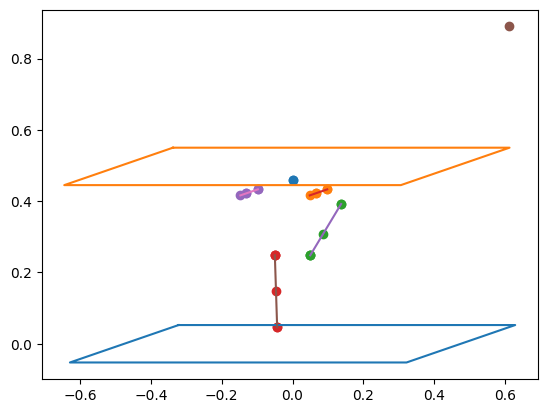

In [16]:
new_joints = dict(joints)
for i, name in enumerate(joint_names):
    new_joints[name] = angles[i]
forward_kinematics(new_joints)
draw_robot(np.array([1, 1, 1, 1]))

In [17]:
#inverse_kinematics(weights, 0.1, 0.2, 0.3, roll=0, pitch=0, yaw=0)